<a href="https://colab.research.google.com/github/MouadCherrat/Netflix_K-means/blob/main/Netflix_k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# - Problem statement:

* Netflix is the world's largest online streaming service provider, with over 220 million subscribers as of 2022. It is crucial that they effectively cluster the shows that are hosted on their platform in order to enhance the user experience, thereby preventing subscriber churn.
* We will be able to understand the shows that are similar to and different from one another by creating clusters, which may be leveraged to offer the consumers personalized show suggestions depending on their preferences.
* The goal of this project is to classify/group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other.

# 1 - Imports

In [ ]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
import re, string, unicodedata
import nltk
#import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
string.punctuation
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
%matplotlib inline
sns.set()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# reading data
path = '/content/sample_data/Netflix_movies_and_tv_shows_clustering.csv'

original_df = pd.read_csv(path,index_col='show_id')
df = original_df.copy()

In [ ]:
df.head()
df.shape

(7787, 11)

# 2 - Cleaning Data



In [ ]:
df.duplicated().value_counts()


,count
False,7787


### 2-1 - Checking for missing values and handling them:

> Ajouter une citation





,0
type,0
title,0
director,2389
cast,718
country,507
date_added,10
release_year,0
rating,7
duration,0
listed_in,0


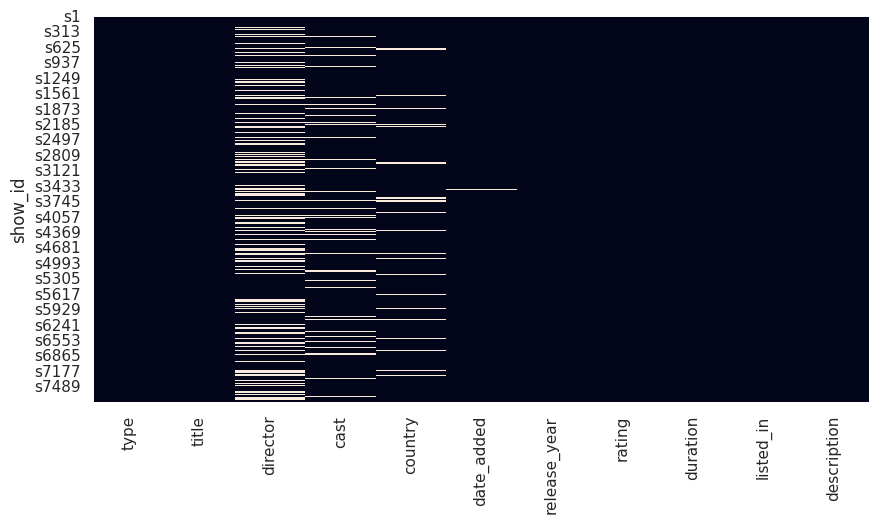

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False)
df.isna().sum()


In [ ]:
df.nunique()


,0
type,2
title,7787
director,4049
cast,6831
country,681
date_added,1565
release_year,73
rating,14
duration,216
listed_in,492


In [ ]:
df[['director','cast','country']] = df[['director','cast','country']].fillna('Unknown')
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
df.dropna(axis=0, inplace = True)

In [ ]:
df.shape


(7777, 11)

In [ ]:
df.country.value_counts()


,count
country,
United States,2549
India,923
Unknown,506
United Kingdom,396
Japan,225
...,...
"Russia, United States, China",1
"Italy, Switzerland, France, Germany",1
"United States, United Kingdom, Canada",1


In [ ]:
df.listed_in.value_counts()


,count
listed_in,
Documentaries,334
Stand-Up Comedy,321
"Dramas, International Movies",320
"Comedies, Dramas, International Movies",243
"Dramas, Independent Movies, International Movies",215
...,...
"Anime Series, Crime TV Shows, TV Thrillers",1
"Crime TV Shows, Romantic TV Shows, Spanish-Language TV Shows",1
"Crime TV Shows, International TV Shows, Reality TV",1







*   There are some movies / TV shows that were filmed in multiple countries, have multiple genres associated with it.
*   To simplify the analysis, let's consider only the primary country where that respective movie / TV show was filmed.



In [ ]:
df['country'] = df['country'].apply(lambda x: x.split(',')[0])
df['listed_in'] = df['listed_in'].apply(lambda x: x.split(',')[0])


In [ ]:
df.country.value_counts()



,count
country,
United States,2877
India,956
United Kingdom,576
Unknown,506
Canada,259
...,...
Zimbabwe,1
Namibia,1
Soviet Union,1


In [ ]:
df.listed_in.value_counts()


,count
listed_in,
Dramas,1384
Comedies,1074
Documentaries,751
Action & Adventure,721
International TV Shows,689
Children & Family Movies,502
Crime TV Shows,369
Kids' TV,357
Stand-Up Comedy,321


### 2-2 - Typecasting 'duration' from string to integer

*   Élément de liste
*   Élément de liste



In [ ]:
# Splitting the duration column, and changing the datatype to integer
df['duration'] = df['duration'].apply(lambda x: int(x.split()[0]))

In [ ]:
df[df['type']=='TV Show'].duration.value_counts()


,count
duration,
1,1608
2,378
3,183
4,86
5,57
6,30
7,19
8,18
9,8


In [ ]:
df[df['type']=='Movie'].duration.unique()


array([ 93,  78,  80, 123,  95, 119, 118, 143, 103,  89,  91, 149, 144,
       124,  87, 110, 128, 117, 100,  84,  99,  90, 102, 104, 105,  56,
       125,  81,  97, 106, 107, 109,  44,  75, 101,  37, 113, 114, 130,
        94, 140, 135,  82,  70, 121,  92, 164,  53,  83, 116,  86, 120,
        96, 126, 129,  77, 137, 148,  28, 122, 176,  85,  22,  68, 111,
        29, 142, 168,  21,  59,  20,  98, 108,  76,  26, 156,  30,  57,
       150, 133, 115, 154, 127, 146, 136,  88, 131,  24, 112,  74,  63,
        38,  25, 174,  60, 153, 158, 151, 162,  54,  51,  69,  64, 147,
        42,  79,  40,  45, 172,  10, 163,  55,  72,  61,  71, 160, 171,
        48, 139, 157,  15,  65, 134, 161,  62, 186,  49,  73,  58, 165,
       166, 138, 159, 141, 132,  52,  67,  34,  66, 312, 180,  47, 155,
        14, 177,  11,   9,  46, 145,   8,  12,  43,  50,  23, 185, 200,
       169,  27, 170, 196,  33, 181, 204,  32,  35, 167, 179, 193,  13,
       214,  17, 173, 192, 209, 187,  41, 182, 224, 233, 189, 15

In [ ]:
df.duration.dtype


dtype('int64')

We have successfully converted the datatype of duration column to int.



### 2-3 - Typecasting 'date_added' from string to datetime

In [ ]:
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")


In [ ]:
df.date_added.min(),df.date_added.max()


(Timestamp('2008-01-01 00:00:00'), Timestamp('2021-01-16 00:00:00'))

In [ ]:
df['month_added'] = df['date_added'].dt.month
df['year_added'] = df['date_added'].dt.year
df.drop('date_added', axis=1, inplace=True)

### 2-4 - Ratings

<Axes: xlabel='rating', ylabel='count'>

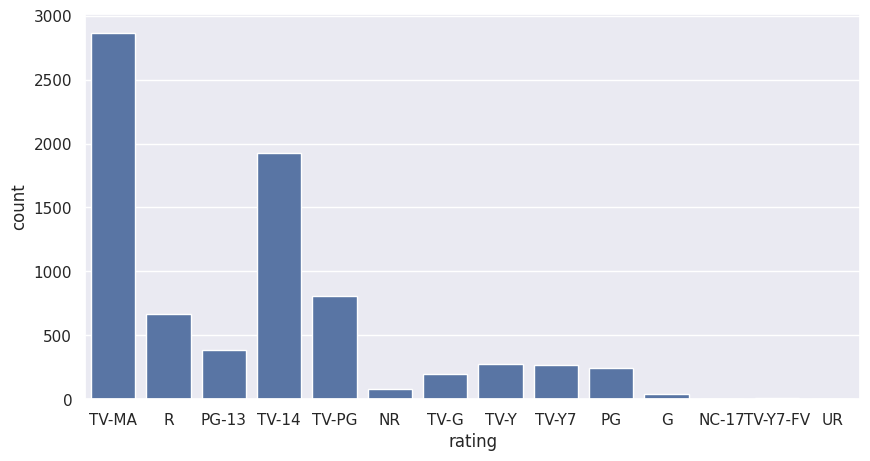

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='rating',data=df)

In [ ]:
df.rating.unique()


array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y',
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

In [ ]:
rating_map = {'TV-MA':'Adults',
              'R':'Adults',
              'PG-13':'Teens',
              'TV-14':'Young Adults',
              'TV-PG':'Older Kids',
              'NR':'Adults',
              'TV-G':'Kids',
              'TV-Y':'Kids',
              'TV-Y7':'Older Kids',
              'PG':'Older Kids',
              'G':'Kids',
              'NC-17':'Adults',
              'TV-Y7-FV':'Older Kids',
              'UR':'Adults'}

df['rating'].replace(rating_map, inplace = True)
df['rating'].unique()

array(['Adults', 'Teens', 'Young Adults', 'Older Kids', 'Kids'],
      dtype=object)

<Axes: xlabel='rating', ylabel='count'>

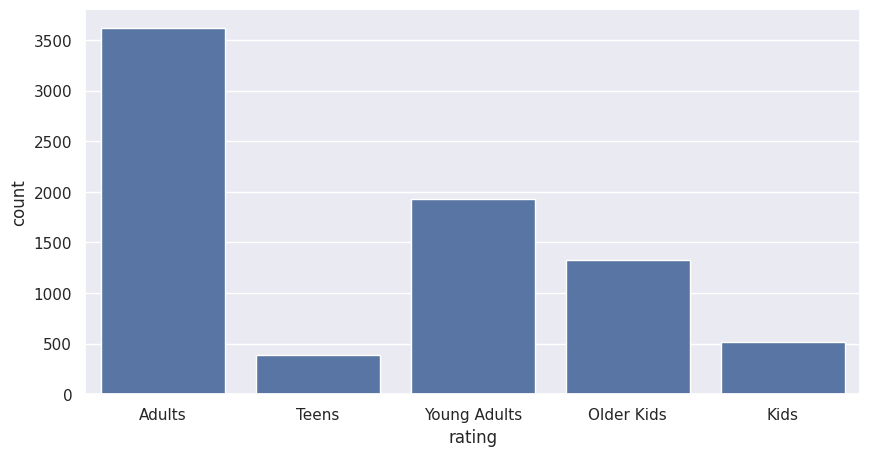

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='rating',data=df)

# 3 - Exploratory Data Analysis:

Text(0.5, 1.0, 'Movies and TV Shows in the dataset')

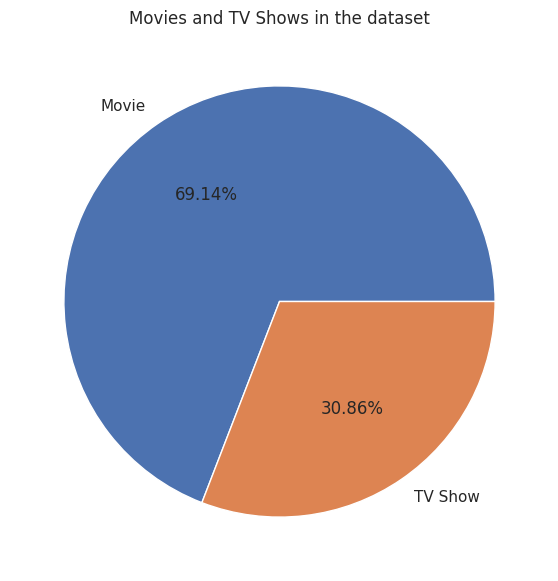

In [ ]:
plt.figure(figsize=(7,7))
df.type.value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.ylabel('')
plt.title('Movies and TV Shows in the dataset')



*   There are more movies (69.14%) than TV shows (30.86%) in the dataset.




Text(0.5, 1.0, 'Top 10 directors by number of shows directed')

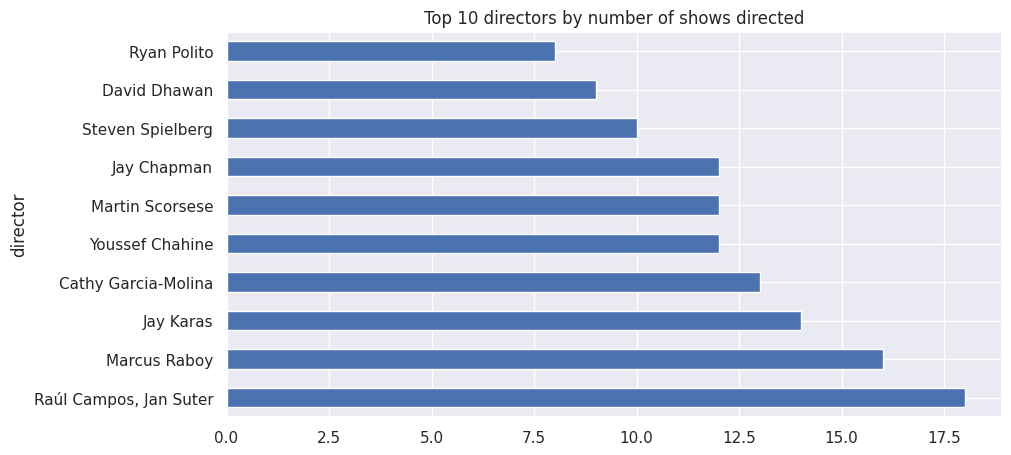

In [ ]:
# Top 10 directors in the dataset
plt.figure(figsize=(10,5))
df[~(df['director']=='Unknown')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 directors by number of shows directed')


* Raul Campos and Jan Suter together have directed 18 movies / TV shows, higher than anyone in the dataset.

Text(0.5, 1.0, ' Top 10 countries with the highest number of shows')

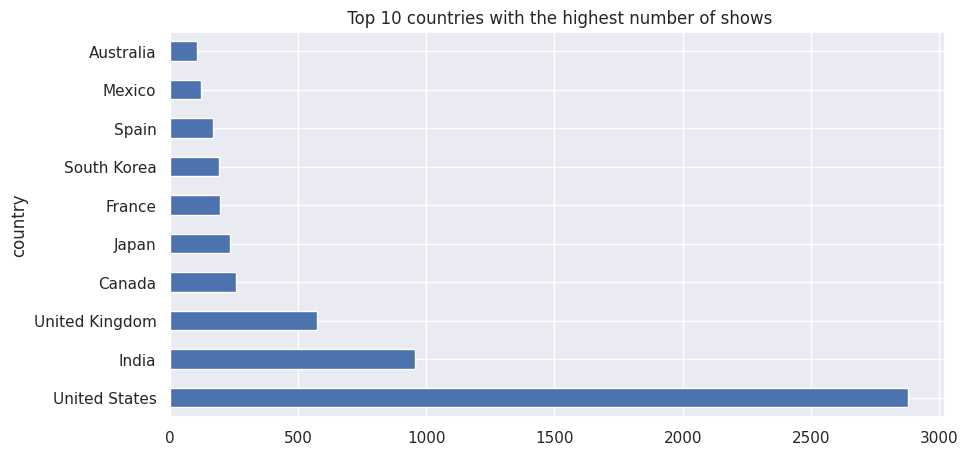

In [ ]:
# Top 10 countries with the highest number movies / TV shows in the dataset
plt.figure(figsize=(10,5))
df[~(df['country']=='Unknown')].country.value_counts().nlargest(10).plot(kind='barh')
plt.title(' Top 10 countries with the highest number of shows')

* The highest number of movies / TV shows were based out of the US, followed by India and UK.


Text(0.5, 1.0, 'distribution by released year')

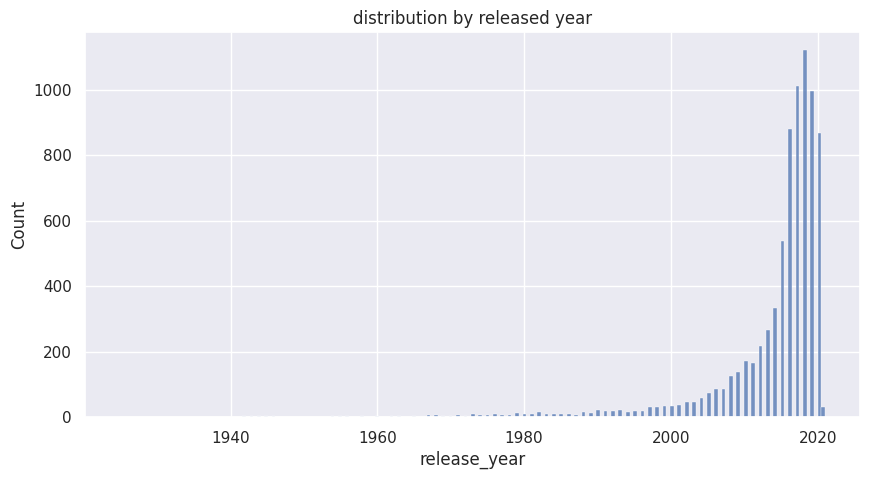

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df['release_year'])
plt.title('distribution by released year')

Text(0.5, 1.0, 'Top 10 genres')

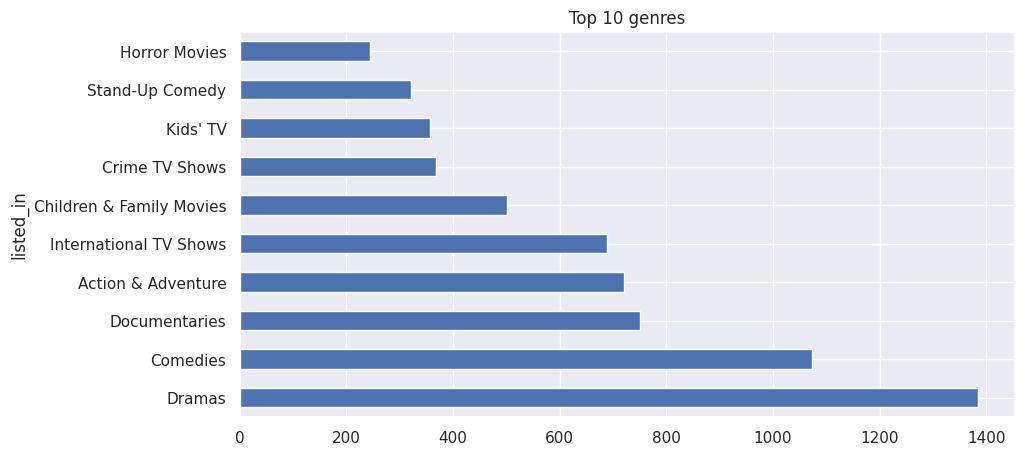

In [ ]:
# Top 10 genres
plt.figure(figsize=(10,5))
df.listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres')

* The dramas is the most popular genre followed by comedies and documentaries.


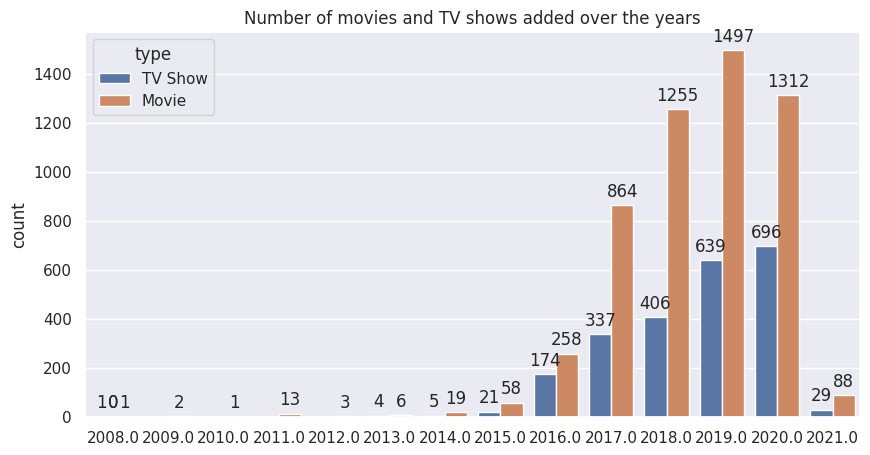

In [ ]:
# Number of movies and TV shows added over the years
plt.figure(figsize=(10,5))
p = sns.countplot(x='year_added',data=df, hue='type')
plt.title('Number of movies and TV shows added over the years')
plt.xlabel('')
for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

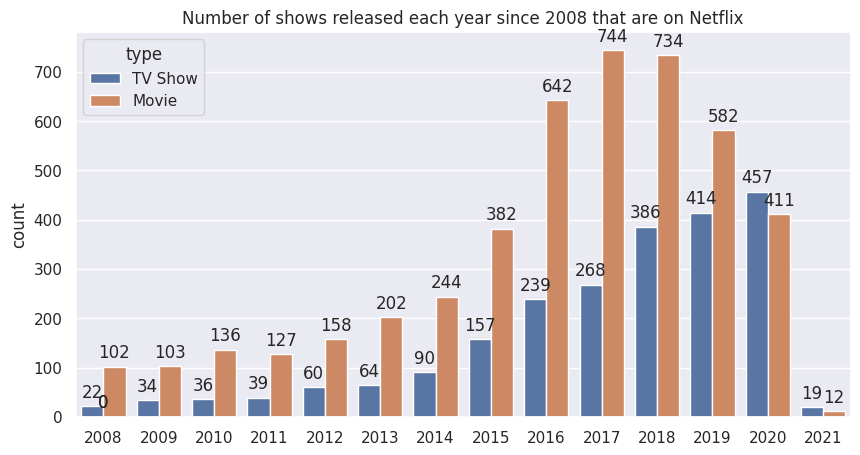

In [ ]:
# Number of shows released each year since 2008
order = range(2008,2022)
plt.figure(figsize=(10,5))
p = sns.countplot(x='release_year',data=df, hue='type',
                  order = order)
plt.title('Number of shows released each year since 2008 that are on Netflix')
plt.xlabel('')
for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

* Over the years, Netflix has consistently focused on adding more shows in its platform.
* Though there was a decrease in the number of movies added in 2020, this pattern did not exist in the number of TV shows added in the same year.
* This might signal that Netflix is increasingly concentrating on introducing more TV series to its platform rather than movies.

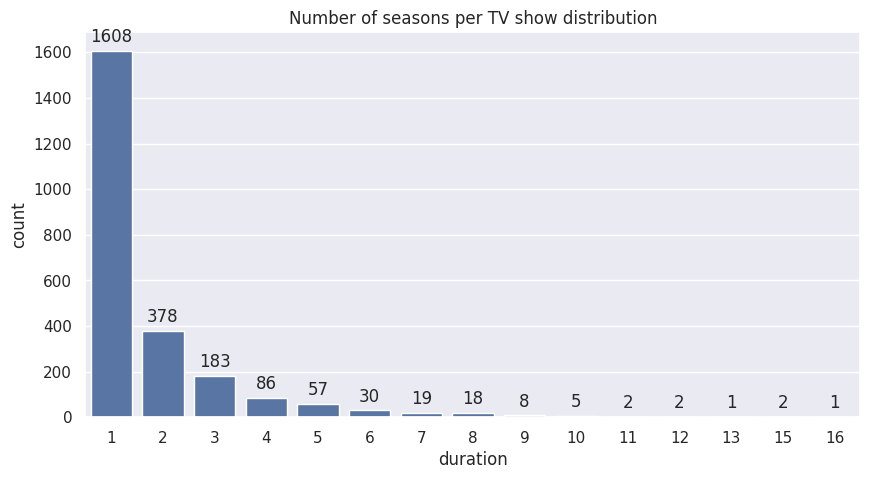

In [ ]:
# Seasons in each TV show
plt.figure(figsize=(10,5))
p = sns.countplot(x='duration',data=df[df['type']=='TV Show'])
plt.title('Number of seasons per TV show distribution')

for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
# % of tv shows with just 1 season
len(df[(df['type']=='TV Show') & (df['duration']==1)]) / len(df[df['type']=='TV Show'])* 100

67.0

* The TV series in the dataset have up to 16 seasons, however the bulk of them only have one. This might mean that the majority of TV shows has only recently begun, and that further seasons are on the way.
* There are very few TV shows that have more than 8 seasons.

Text(0.5, 1.0, 'Movie duration distribution')

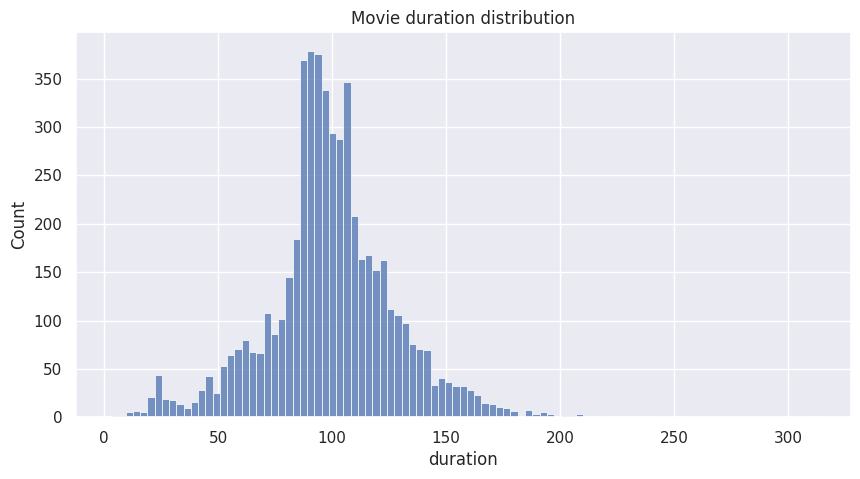

In [ ]:
# length of movie analysis
plt.figure(figsize=(10,5))
sns.histplot(x='duration',data=df[df['type']=='Movie'])
plt.title('Movie duration distribution')

In [ ]:
df[df['type']== 'Movie'].duration.describe()


,duration
count,5377.000000
mean,99.307978
std,28.530881
min,3.000000
25%,86.000000
50%,98.000000
75%,114.000000
max,312.000000


The length of a movie may range from 3 min to 312 minutes, and the distribution is almost normally distributed.

Text(0.5, 0, 'Year')

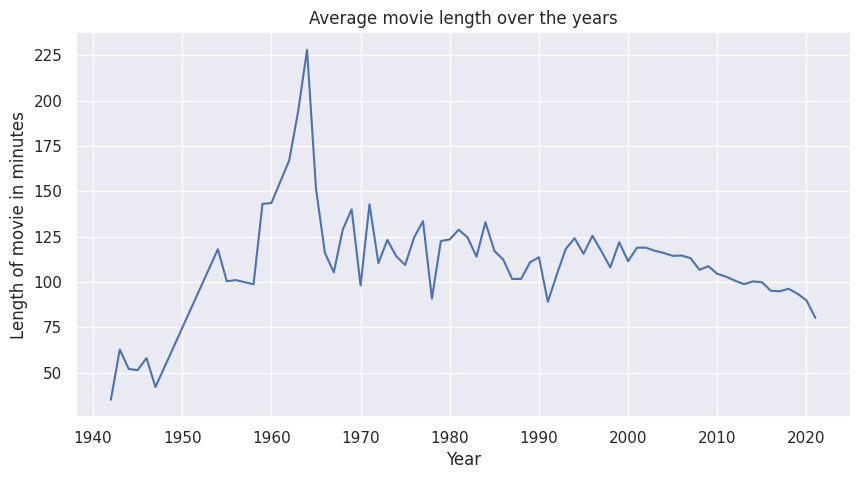

In [ ]:
# Average movie length over the years
plt.figure(figsize=(10,5))
df[df['type']=='Movie'].groupby('release_year')['duration'].mean().plot(kind='line')
plt.title('Average movie length over the years')
plt.ylabel('Length of movie in minutes')
plt.xlabel('Year')

In [ ]:
df[df['type']== 'Movie'].release_year.describe()


,release_year
count,5377.000000
mean,2012.920030
std,9.663282
min,1942.000000
25%,2012.000000
50%,2016.000000
75%,2018.000000
max,2021.000000


Text(0.5, 1.0, 'Top 10 genres for movies')

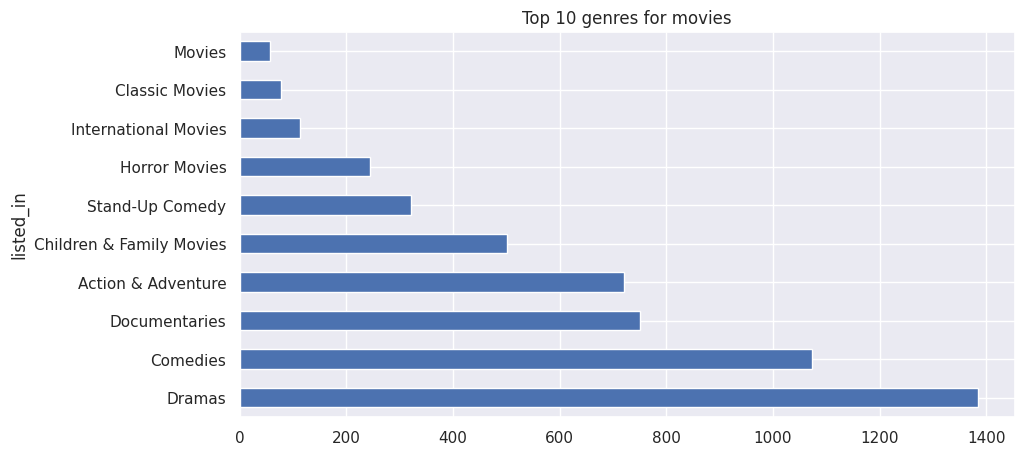

In [ ]:
# Top 10 genre for movies
plt.figure(figsize=(10,5))
df[df['type']=='Movie'].listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres for movies')

* Dramas, comedies, and documentaries are the most popular genre for the movies on Netflix.


Text(0.5, 1.0, 'Top 10 genres for TV Shows')

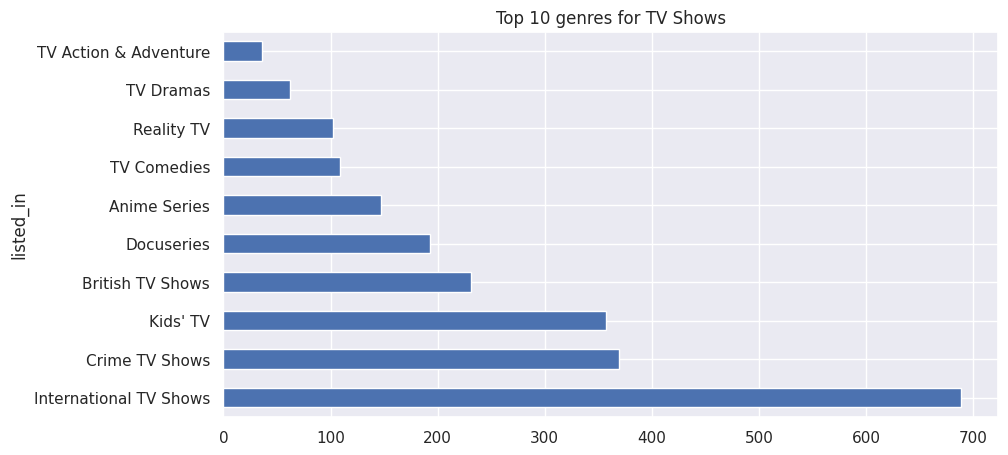

In [ ]:
# Top 10 genre for tv shows
plt.figure(figsize=(10,5))
df[df['type']=='TV Show'].listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres for TV Shows')

* International, crime, and kids are the most popular genre for TV shows on Netflix.


Text(0.5, 1.0, 'Top 10 movie directors')

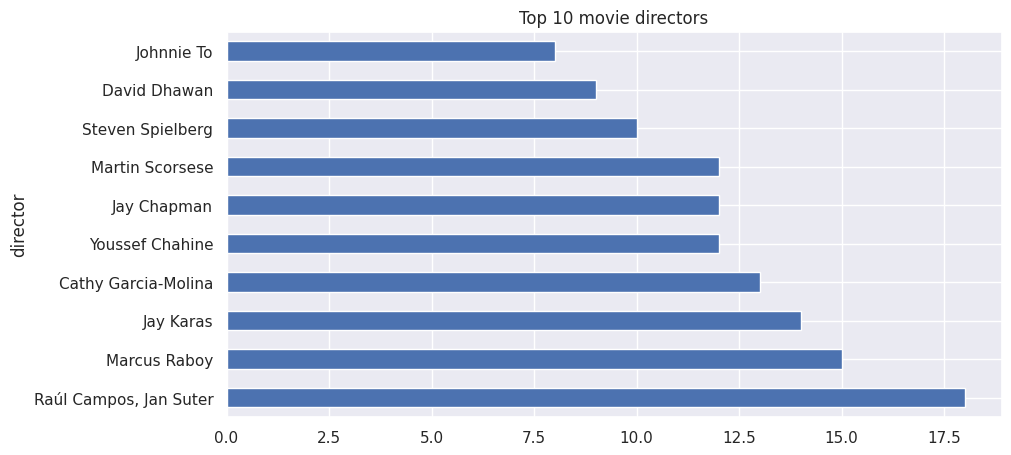

In [ ]:
# Top 10 movie directors
plt.figure(figsize=(10,5))
df[~(df['director']=='Unknown') & (df['type']=='Movie')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 movie directors')

Text(0.5, 1.0, 'Top 10 TV show directors')

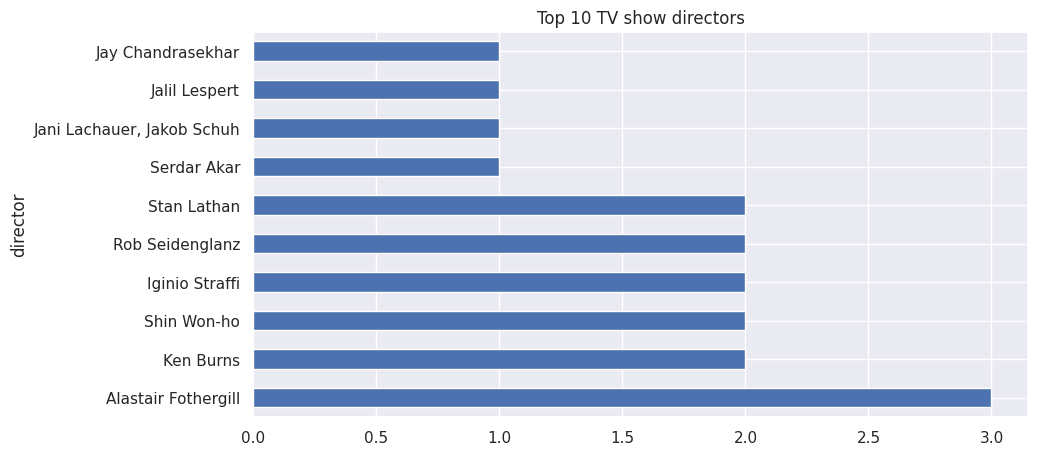

In [ ]:
# Top 10 TV show directors
plt.figure(figsize=(10,5))
df[~(df['director']=='Unknown') & (df['type']=='TV Show')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 TV show directors')

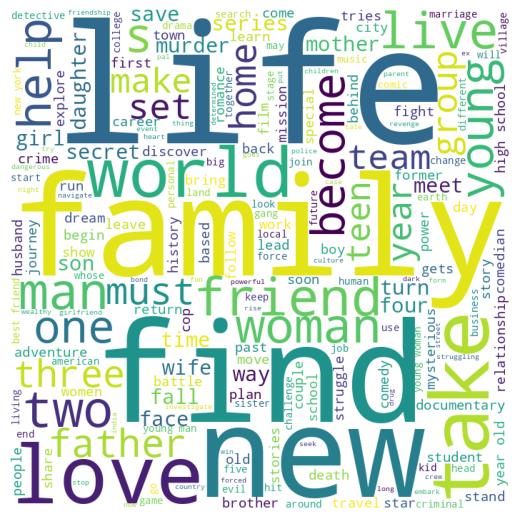

In [ ]:
# Building a wordcloud for the movie descriptions
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.description.values:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (10,5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

* Some keywords in Netflix show descriptions: life, family, new, love, young, world, group, death, man, woman, murder, son, girl, documentary, secret.

# 4 - Data Processing :

### 4-1 Modeling Approach :


1.   Select the attributes based on which you want to cluster the shows

2.   Text preprocessing: Remove all non-ascii characters, stopwords and punctuation marks, convert all textual data to lowercase.
3.   Transformers



We will cluster the shows on Netflix based on the following attributes:

* Director
* Cast
* Country
* Listed in (genres)
* Description

In [ ]:
# Using the original dataset for clustering since
# it does not require handling missing values
df1 = original_df.copy()

In [ ]:
df1.fillna('',inplace=True)


In [ ]:
# Combining all the clustering attributes into a single column

df1['clustering_attributes'] = (df1['director'] + ' ' +
                                df1['cast'] +' ' +
                                df1['country'] +' ' +
                                df1['listed_in'] +' ' +
                                df1['description'])

In [ ]:
df1['clustering_attributes'][40]


'Muharrem Gülmez Erdem Yener, Ayhan Taş, Emin Olcay, Muharrem Gülmez, Elif Nur Kerkük, Tarık Papuççuoğlu, Suzan Aksoy, Doğa Konakoğlu, Esin Eden, Deniz Özerman Turkey Comedies, International Movies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall.'

* We have successfully added all the necessary data into a single column


### 4-2 - Removing non-ASCII Characters:

In [ ]:
def remove_non_ascii(words):
    """Function to remove non-ASCII characters"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [ ]:
# remove non-ascii characters
df1['clustering_attributes'] = remove_non_ascii(df1['clustering_attributes'])

In [ ]:
df1['clustering_attributes'][40]


'Muharrem Gulmez Erdem Yener, Ayhan Tas, Emin Olcay, Muharrem Gulmez, Elif Nur Kerkuk, Tark Papuccuoglu, Suzan Aksoy, Doga Konakoglu, Esin Eden, Deniz Ozerman Turkey Comedies, International Movies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall.'

* We have successfully removed all non-ascii characters from the corpus.


### 4-2 - Transformers:

In [ ]:
from sentence_transformers import SentenceTransformer

# Charger le modèle Sentence Transformers
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Générer des embeddings pour la colonne 'clustering_attributes'
embeddings = model.encode(df1['clustering_attributes'].tolist(), show_progress_bar=True)

# Afficher la taille des embeddings générés
print(f"Shape of embeddings: {embeddings.shape}")


Batches:   0%|          | 0/244 [00:00<?, ?it/s]

Shape of embeddings: (7787, 384)


* Purpose: This step replaces traditional preprocessing (stopwords removal, punctuation removal, lemmatization, etc.) with a modern NLP approach.
* Output: Dense numerical vectors representing the textual data.

### 4-3 - Dimensionality reduction using PCA:


* We can use PCA (Principal component Analysis) to reduce the dimensionality of data.

In [ ]:
pca = PCA(random_state=42)
pca.fit(embeddings)

PCA(random_state=42)

Text(0, 0.5, 'Cumulative Explained Variance')

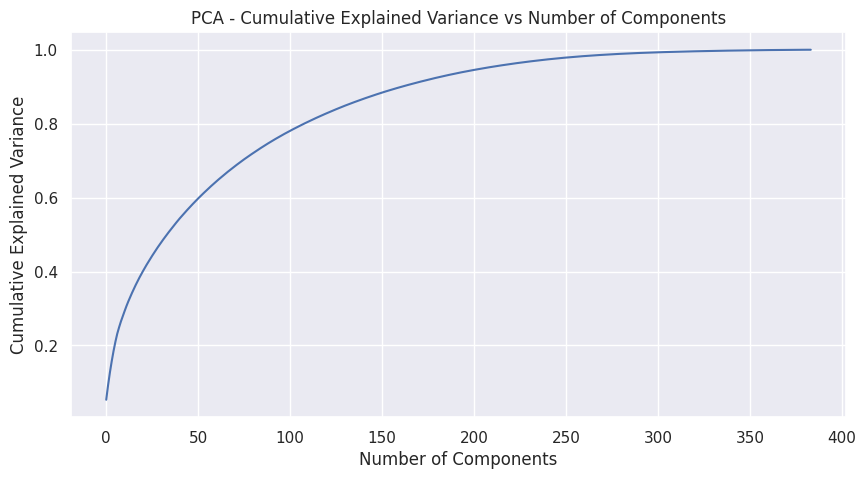

In [ ]:
# Plot the cumulative explained variance to find the optimal number of components
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')


In [ ]:
n_components = 200

# Apply PCA to reduce embeddings to the chosen number of dimensions
pca = PCA(n_components=n_components, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

# Print the shape of the reduced embeddings
print(f"Shape of reduced embeddings: {reduced_embeddings.shape}")

Shape of reduced embeddings: (7787, 200)


We have successfully reduced the dimensionality of data using PCA.



### 4-4 - Gain Informations:

Imports :


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Charger les donnes

In [ ]:
# Charger les données depuis le fichier CSV
data = pd.read_csv("sample_data/Netflix_movies_and_tv_shows_clustering.csv")

# Vérifiez les premières lignes des données pour confirmer le chargement
print("Aperçu des données :")
print(data.head())

# Vérifiez la structure des données pour identifier les colonnes disponibles
print("\nStructure des données :")
print(data.info())

# Définir la colonne cible
target_column = 'type'  # Remplacez 'type' par le nom réel de votre colonne cible
if target_column not in data.columns:
    raise ValueError(f"La colonne cible '{target_column}' n'existe pas dans le fichier.")


Aperçu des données :
  show_id     type  title           director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie   7:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                cast        country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

          date_added  release_year rating   duration  \
0    August 14, 2020          2020  TV-MA  4 Seasons   
1  December 23, 2016          2016  TV-MA     93 min   
2  December 20, 2018          2011      R     78 min   
3  November 16, 2017          2009  PG-


Définition des fonctions pour l'entropie et le gain d'information


In [ ]:
def entropy(column):
    """
    Calcule l'entropie d'une colonne.
    :param column: Série pandas
    :return: Entropie
    """
    counts = column.value_counts()
    probabilities = counts / len(column)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # 1e-9 pour éviter log(0)

def information_gain(data, feature, target):
    """
    Calcule le gain d'information pour une colonne spécifique.
    :param data: DataFrame
    :param feature: Nom de la colonne à évaluer
    :param target: Nom de la colonne cible
    :return: Gain d'information
    """
    # Entropie totale de la cible
    total_entropy = entropy(data[target])

    # Calcul de l'entropie pondérée après séparation
    values, counts = np.unique(data[feature], return_counts=True)
    weighted_entropy = np.sum([
        (counts[i] / np.sum(counts)) * entropy(data[data[feature] == values[i]][target])
        for i in range(len(values))
    ])

    # Calcul du gain d'information
    return total_entropy - weighted_entropy



 Calcul du gain d'information pour chaque caractéristique


In [ ]:
# Prétraitement pour corriger les types de données dans les colonnes des caractéristiques
for column in data.columns:
    if data[column].dtype == 'object':  # Si la colonne contient des chaînes
        data[column] = data[column].fillna("Unknown")  # Remplace les valeurs manquantes par 'Unknown'
    else:
        data[column] = data[column].fillna(-1)  # Remplace les valeurs numériques manquantes par -1

# Identifier les colonnes des caractéristiques (toutes sauf la colonne cible)
features = data.columns.drop(target_column)

# Calculer le gain d'information pour chaque caractéristique
gains = {}
for feature in features:
    try:
        gains[feature] = information_gain(data, feature, target_column)
    except Exception as e:
        print(f"Erreur avec la colonne {feature}: {e}")

# Afficher les résultats
print("\nGain d'information par caractéristique :")
for feature, gain in gains.items():
    print(f"{feature}: {gain}")



Gain d'information par caractéristique :
show_id: 0.8925840758560103
title: 0.8925840758560103
director: 0.7703078847461043
cast: 0.79159759660038
country: 0.18527988520312832
date_added: 0.2697473705985475
release_year: 0.04734237549394493
rating: 0.11943594798234491
duration: 0.8925840758560103
listed_in: 0.8925840758560103
description: 0.8919734571973548


Visualisation des résultats


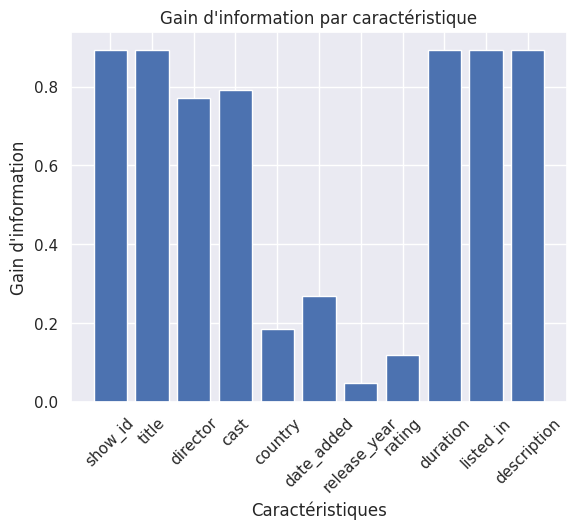

In [ ]:
# Visualisation des gains d'information
plt.bar(gains.keys(), gains.values())
plt.title("Gain d'information par caractéristique")
plt.xticks(rotation=45)
plt.ylabel("Gain d'information")
plt.xlabel("Caractéristiques")
plt.show()

### 4-5 - Firefly Algorithm:

Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances  # For distance calculations


Data Preprocessing

In [ ]:
def preprocess_data(df):
    """
    Preprocesses the dataset by extracting numeric features and encoding categorical data.
    """
    # Ensure the 'duration' column is treated as a string
    if 'duration' in df.columns:
        df['duration'] = df['duration'].astype(str)  # Convert to string if not already
        df['duration_minutes'] = df['duration'].str.extract(r'(\d+)').astype(float)
    else:
        df['duration_minutes'] = np.nan

    # Encode the 'rating' column
    if 'rating' in df.columns:
        rating_mapping = {rating: idx for idx, rating in enumerate(df['rating'].dropna().unique())}
        df['rating_encoded'] = df['rating'].map(rating_mapping)
    else:
        df['rating_encoded'] = np.nan

    # Select relevant columns
    if {'release_year', 'duration_minutes', 'rating_encoded'}.issubset(df.columns):
        numeric_data = df[['release_year', 'duration_minutes', 'rating_encoded']].dropna()
    else:
        numeric_data = pd.DataFrame()

    # Check if data is valid
    if numeric_data.empty:
        print("No valid data found for clustering!")
    else:
        print(f"Preprocessed data shape: {numeric_data.shape}")

    return numeric_data.values


Firefly Algorithm

In [ ]:
def firefly_algorithm(data, num_fireflies=10, max_iter=50, gamma=1.0, alpha=0.2, beta=1.0, num_clusters=3):
    """
    Implements the Firefly Algorithm for clustering.
    """
    np.random.seed(42)

    # Initialize fireflies with random cluster centers
    fireflies = [data[np.random.choice(data.shape[0], num_clusters, replace=False)] for _ in range(num_fireflies)]
    intensities = [evaluate_solution(data, firefly) for firefly in fireflies]

    for iteration in range(max_iter):
        for i in range(num_fireflies):
            for j in range(num_fireflies):
                if intensities[j] < intensities[i]:  # Move firefly i towards firefly j
                    distance = np.linalg.norm(fireflies[i] - fireflies[j])
                    beta_attractiveness = beta * np.exp(-gamma * distance ** 2)
                    fireflies[i] += beta_attractiveness * (fireflies[j] - fireflies[i])
                    fireflies[i] += alpha * (np.random.rand(*fireflies[i].shape) - 0.5)

                    # Ensure centers remain within data bounds
                    fireflies[i] = np.clip(fireflies[i], data.min(axis=0), data.max(axis=0))

                    # Update intensity
                    intensities[i] = evaluate_solution(data, fireflies[i])

        print(f"Iteration {iteration + 1}/{max_iter}, Best Intensity: {min(intensities)}")

    # Return the best solution
    best_firefly = fireflies[np.argmin(intensities)]
    return best_firefly


Solution Evaluation

In [ ]:
def evaluate_solution(data, centroids):
    """
    Evaluates a solution based on within-cluster sum of squared distances (WCSS).
    """
    distances = pairwise_distances(data, centroids, metric='euclidean')
    closest_cluster = np.argmin(distances, axis=1)
    wcss = sum(np.sum((data[closest_cluster == k] - centroids[k]) ** 2) for k in range(len(centroids)))
    return wcss


Assign Clusters

In [ ]:
def assign_clusters(data, centroids):
    """
    Assigns data points to the nearest cluster centroid.
    """
    distances = pairwise_distances(data, centroids, metric='euclidean')
    return np.argmin(distances, axis=1)


Execute Firefly Algorithm

In [ ]:
# Preprocess the data
data = preprocess_data(df)

# Run the Firefly Algorithm if the data is valid
if data.shape[0] == 0:
    print("Error: No data available for clustering. Please check your preprocessing steps.")
else:
    # Find the best cluster centers
    best_centroids = firefly_algorithm(data, num_fireflies=15, max_iter=100, num_clusters=5)

    # Assign clusters
    clusters = assign_clusters(data, best_centroids)
    df['Cluster'] = np.nan
    df.loc[df.index[:len(clusters)], 'Cluster'] = clusters

    # Save the results
    df.to_csv('Netflix_Clustered_Data.csv', index=False)
    print("Clustering completed. Results saved to 'Netflix_Clustered_Data.csv'.")


Preprocessed data shape: (7777, 3)
Iteration 1/100, Best Intensity: 1684578.0
Iteration 2/100, Best Intensity: 1684578.0
Iteration 3/100, Best Intensity: 1684578.0
Iteration 4/100, Best Intensity: 1684578.0
Iteration 5/100, Best Intensity: 1684578.0
Iteration 6/100, Best Intensity: 1684578.0
Iteration 7/100, Best Intensity: 1684578.0
Iteration 8/100, Best Intensity: 1684578.0
Iteration 9/100, Best Intensity: 1684578.0
Iteration 10/100, Best Intensity: 1684578.0
Iteration 11/100, Best Intensity: 1684578.0
Iteration 12/100, Best Intensity: 1684578.0
Iteration 13/100, Best Intensity: 1684578.0
Iteration 14/100, Best Intensity: 1684578.0
Iteration 15/100, Best Intensity: 1684578.0
Iteration 16/100, Best Intensity: 1684578.0
Iteration 17/100, Best Intensity: 1684578.0
Iteration 18/100, Best Intensity: 1684578.0
Iteration 19/100, Best Intensity: 1684578.0
Iteration 20/100, Best Intensity: 1684578.0
Iteration 21/100, Best Intensity: 1684578.0
Iteration 22/100, Best Intensity: 1684578.0
Iterat

### 4-6 - Mutual Informations:

Encoding Categorical Features

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
label_encoders = {}
categorical_columns = ['type', 'rating', 'country']
for column in categorical_columns:
    le = LabelEncoder()
    df1[column] = le.fit_transform(df1[column])
    label_encoders[column] = le


TF-IDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization for `description`
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
tfidf_matrix = vectorizer.fit_transform(df1['description'])


Mutual Information Calculation

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Calculate Mutual Information (MI) for `type` with TF-IDF features
mi_scores = mutual_info_classif(tfidf_matrix, df1['type'])

# Prepare a summary of MI scores
mi_scores_summary = pd.DataFrame({
    'Feature': vectorizer.get_feature_names_out(),
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

# Display MI scores summary
print(mi_scores_summary)


         Feature  MI_Score
265         life  0.060244
318          new  0.048589
499        young  0.047817
494        world  0.047534
389       series  0.047321
..           ...       ...
54   businessman  0.002324
183       french  0.002284
24      attempts  0.002229
394       shares  0.002208
242    kidnapped  0.002119

[500 rows x 2 columns]


# 5 - Cluster Implementation:

### 5-1 - K-means Clustring:

In [ ]:
wcss=[]
for i in range(1,31):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=33)
  kmeans.fit(reduced_embeddings)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,31)
plt.figure(figsize=(10,5))
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method - KMeans clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

* The sum of squared distance between each point and the centroid in a cluster (WCSS) decreases with the increase in the number of clusters.

In [ ]:
# Plotting Silhouette score for different umber of clusters
range_n_clusters = range(2,31)
silhouette_avg = []
for num_clusters in range_n_clusters:
  # initialize kmeans
  kmeans = KMeans(n_clusters=num_clusters,init='k-means++',random_state=33)
  kmeans.fit(reduced_embeddings)
  cluster_labels = kmeans.labels_

  # silhouette score
  silhouette_avg.append(silhouette_score(reduced_embeddings, cluster_labels))

plt.figure(figsize=(10,5))
plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k - KMeans clustering')
plt.show()

* The highest Silhouette score is obtained for 6 clusters.

Building 6 clusters using the k-means clustering algorithm:



In [ ]:
kmeans = KMeans(n_clusters=6,init='k-means++',random_state=33)
kmeans.fit(reduced_embeddings)

In [ ]:
kmeans_distortion = kmeans.inertia_
kmeans_silhouette_score = silhouette_score(reduced_embeddings, kmeans.labels_)

print((kmeans_distortion,kmeans_silhouette_score))

In [ ]:
# Adding a kmeans cluster number attribute
df1['kmeans_cluster'] = kmeans.labels_

In [ ]:
# Number of movies and tv shows in each cluster
plt.figure(figsize=(10,5))
q = sns.countplot(x='kmeans_cluster',data=df1, hue='type')
plt.title('Number of movies and TV shows in each cluster - Kmeans Clustering')
for i in q.patches:
  q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

* Successfully built 6 clusters using the k-means clustering algorithm.



### 5-2 - Building wordclouds for different clusters built:

In [ ]:
# Building a wordcloud for the movie descriptions
def kmeans_worldcloud(cluster_num):
  comment_words = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in df1[df1['kmeans_cluster']==cluster_num].description.values:

      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()

      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()

      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 700, height = 700,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)

 # plot the WordCloud image
  plt.figure(figsize = (10,5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

In [ ]:
# Wordcloud for cluster 0
kmeans_worldcloud(0)

* Keywords observed in cluster 0: life, new, family, friend, save, help, discover, home, teen



In [ ]:
kmeans_worldcloud(1)


* Keywords observed in cluster 1: life, love, family, father, young, girl, man, woman, friend, daughter



In [ ]:
kmeans_worldcloud(2)


* Keywords observed in cluster 2: young, world, girl, mysterious, humanity, life, student, school, battle, demon, force

In [ ]:
# Wordcloud for cluster 3
kmeans_worldcloud(3)

* Keywords observed in cluster 3: love, life, family, romance, crime, murder, world, adventure



In [ ]:
# Wordcloud for cluster 4
kmeans_worldcloud(4)

* Keywords observed in cluster 4: love, life, stand, comic, stage, friend, joke



In [ ]:
# Wordcloud for cluster 5
kmeans_worldcloud(5)

* Keywords observed in cluster 5: documentary, world, life, filmmaker, american, life



### 5-3 - Hierarchical clustering:

Building clusters using the agglomerative (hierarchical) clustering algorithm.



Visualizing the dendrogram to decide on the optimal number of clusters for the agglomerative (hierarchical) clustering algorithm:

In [ ]:
# Building a dendogram to decide on the number of clusters
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(reduced_embeddings, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Netflix Shows')
plt.ylabel('Distance')
plt.axhline(y= 3.8, color='r', linestyle='--')

* At a distance of 3.8 units, 12 clusters can be built using the agglomerative clustering algorithm.



### 5-4 - SVM Clustring :

In [ ]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=33)
kmeans.fit(reduced_embeddings)

# Add cluster labels to the dataframe
df1['kmeans_cluster'] = kmeans.labels_

# Prepare the data for SVM
X = reduced_embeddings
y = df1['kmeans_cluster']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Evaluate the SVM
y_pred = svm_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


TF-IDF Vectorization for Descriptions

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
df['description'] = df['description'].fillna('')

# Initialize and fit TF-IDF vectorizer
print("Fitting TF-IDF vectorizer...")
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['description'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Apply PCA to the TF-IDF matrix
print("Applying PCA to reduce dimensions...")
pca = PCA(n_components=200, random_state=42)
reduced_embeddings = pca.fit_transform(tfidf_matrix.toarray())
print(f"Reduced embeddings shape: {reduced_embeddings.shape}")

# Print explained variance ratio
print("Explained variance ratio of PCA:")
print(np.cumsum(pca.explained_variance_ratio_))


Predict Clusters for New Data

In [ ]:
new_descriptions = [
    "A thrilling adventure in space.",
    "A romantic comedy about two strangers.",
    "A historical documentary on ancient civilizations."
]

# Transform the new descriptions using TF-IDF and PCA
new_tfidf_matrix = tfidf.transform(new_descriptions)
new_reduced_embeddings = pca.transform(new_tfidf_matrix.toarray())

# Predict clusters using the trained SVM model
predicted_clusters = svm_model.predict(new_reduced_embeddings)
print("Predicted clusters for new data points:", predicted_clusters)


Visualize SVM Classification Results

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x=y_pred, order=np.unique(y_pred))
plt.title('Predicted Cluster Distribution by SVM')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Data Points')
plt.show()


Visualize Cluster Centroids

In [ ]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
reduced_embeddings_2d = pca_2d.fit_transform(reduced_embeddings)
centroids_2d = pca_2d.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_embeddings_2d[:, 0], reduced_embeddings_2d[:, 1], c=kmeans.labels_, cmap='viridis', s=10)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('K-Means Clustering with PCA (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
